<a href="https://colab.research.google.com/github/Kelly0604/ECE661_Final/blob/main/ResNet56_WhiteBox_SAGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECE 661 Final

ResNet56 on White-box attacks

In [1]:
# conenct to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/661FinalProject')

In [3]:
!ls

661FinalProject.ipynb		   imagenet21k_ViT-B_32.npz
AttackWrappersAdaptiveBlackBox.py  ModelPlus.py
AttackWrappersRayS.py		   __pycache__
AttackWrappersSAGA.py		   resnet56_cifar10_2.pth
AttackWrappersWhiteBoxP.py	   ResNetPytorch.py
BigTransferModels.py		   TransformerConfigs.py
BiT-M-R101x3-Run0.tar		   TransformerModels.py
data				   TransformerResNet.py
DataLoaderGiant.py		   VisionTransformersRobustness.py
DataManagerPytorch.py		   ViT-L_16,cifar10,run0_15K_checkpoint.bin
DefaultMethods.py


Preparing Environment

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Import your ResNet model and attack functions
from ResNetPytorch import resnet56
from AttackWrappersWhiteBoxP import FGSMNativePytorch, MIMNativePytorch


Loading ResNet56

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet56(inputImageSize=32, numClasses=10).to(device)

In [5]:
# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decay every 30 epochs

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [ ]:
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

/content/drive/MyDrive/ECE Final/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Epoch 1/20, Train Loss: 2.2412, Train Acc: 19.77%, Val Loss: 2.1882, Val Acc: 25.99%
Epoch 2/20, Train Loss: 2.1348, Train Acc: 32.70%, Val Loss: 2.0843, Val Acc: 37.84%
Epoch 3/20, Train Loss: 2.0657, Train Acc: 39.56%, Val Loss: 2.0202, Val Acc: 44.34%
Epoch 4/20, Train Loss: 2.0194, Train Acc: 44.17%, Val Loss: 2.0281, Val Acc: 42.91%
Epoch 5/20, Train Loss: 1.9761, Train Acc: 48.82%, Val Loss: 1.9681, Val Acc: 49.32%
Epoch 6/20, Train Loss: 1.9392, Train Acc: 52.59%, Val Loss: 1.9280, Val Acc: 53.47%
Epoch 7/20, Train Loss: 1.9048, Train Acc: 56.03%, Val Loss: 1.8923, Val Acc: 56.70%
Epoch 8/20, Train Loss: 1.8748, Train Acc: 59.03%, Val Loss: 1.8737, Val Acc: 58.83%
Epoch 9/20, Train Loss: 1.8471, Train Acc: 62.07%, Val Loss: 1.8218, Val Acc: 64.15%
Epoch 10/20, Train Loss: 1.8252, Train Acc: 64.16%, Val Loss: 1.8224, Val Acc: 64.27%
Epoch 11/20, Train Loss: 1.8046, Train Acc: 66.12%, Val Loss: 1.7992, Val Acc: 66.18%
Epoch 12/20, Train Loss: 1.7834, Train Acc: 68.41%, Val Loss: 1

In [ ]:
torch.save(model.state_dict(), "resnet56_cifar10_2.pth")
print("Model saved as resnet56_cifar10.pth")

Model saved as resnet56_cifar10.pth


In [ ]:
model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))
model.eval()

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

<ipython-input-54-a271931a23ba>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))


Test Loss: 1.6942, Test Accuracy: 77.24%


Adversarial Attacks

In [ ]:
model = resnet56(inputImageSize=32, numClasses=10).to(device)
model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))
model.eval()

<ipython-input-72-ae9f0afdf0ac>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet56_cifar10_2.pth"))


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      

In [ ]:
# FGSM
epsilon = 0.05  # Perturbation magnitude
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using FGSMNativePytorch
adv_loader_FGSM = FGSMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

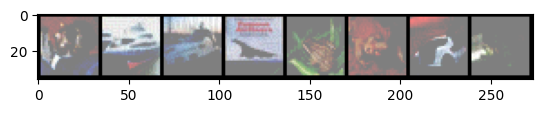

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Get a batch of adversarial examples
for adv_images, labels in adv_loader_FGSM:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5  # Assuming CIFAR-10 normalization

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
# MIM
# Define parameters
epsilon = 0.1  # Maximum perturbation magnitude
epsilon_step = 0.005  # Step size for each iteration
num_steps = 10  # Number of attack iterations
decay_factor = 1.0  # Momentum decay factor
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using MIMNativePytorch
adv_loader_MIM = MIMNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    decayFactor=decay_factor,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

Processing up to sample= 64
Processing up to sample= 128
Processing up to sample= 192
Processing up to sample= 256
Processing up to sample= 320
Processing up to sample= 384
Processing up to sample= 448
Processing up to sample= 512
Processing up to sample= 576
Processing up to sample= 640
Processing up to sample= 704
Processing up to sample= 768
Processing up to sample= 832
Processing up to sample= 896
Processing up to sample= 960
Processing up to sample= 1024
Processing up to sample= 1088
Processing up to sample= 1152
Processing up to sample= 1216
Processing up to sample= 1280
Processing up to sample= 1344
Processing up to sample= 1408
Processing up to sample= 1472
Processing up to sample= 1536
Processing up to sample= 1600
Processing up to sample= 1664
Processing up to sample= 1728
Processing up to sample= 1792
Processing up to sample= 1856
Processing up to sample= 1920
Processing up to sample= 1984
Processing up to sample= 2048
Processing up to sample= 2112
Processing up to sample= 2

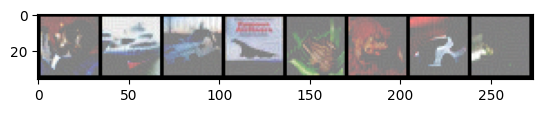

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_MIM:
    break

# Unnormalize for visualization (assuming CIFAR-10 normalization)
adv_images = adv_images * 0.5 + 0.5  # If normalized to [-1, 1], reverse to [0, 1]

# Plot the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
def PGDNativePytorch(device, dataLoader, model, epsilonMax, epsilonStep, numSteps, clipMin, clipMax, targeted):
    model.eval()  # Set model to evaluation mode
    # Generate variables for storing the adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0
    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        batchSize = xData.shape[0]
        advImages = xData.clone().detach()

        # PGD iterations
        for _ in range(numSteps):
            advImages.requires_grad = True
            outputs = model(advImages)
            loss = torch.nn.CrossEntropyLoss()(outputs, yData)
            model.zero_grad()
            loss.backward()

            # Generate adversarial perturbations
            gradSign = advImages.grad.sign()
            if targeted:
                advImages = advImages - epsilonStep * gradSign  # Targeted: decrease towards target
            else:
                advImages = advImages + epsilonStep * gradSign  # Untargeted: increase loss

            # Project adversarial examples to epsilon-ball and clip to valid range
            advImages = torch.clamp(advImages, xData - epsilonMax, xData + epsilonMax)
            advImages = torch.clamp(advImages, clipMin, clipMax).detach()

        # Save adversarial examples
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [ ]:
# Define PGD parameters
epsilon = 0.05  # Maximum perturbation magnitude
epsilon_step = 0.01  # Step size
num_steps = 10  # Number of attack iterations
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using PGD
adv_loader_PGD = PGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    epsilonStep=epsilon_step,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max,
    targeted=targeted
)

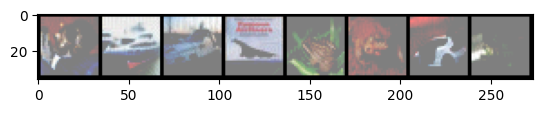

In [ ]:
import matplotlib.pyplot as plt
import torchvision
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_PGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5
# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [ ]:
!pip install torchattacks

In [ ]:
import torchattacks

def APGDNativePytorch(device, dataLoader, model, epsilonMax, numSteps, clipMin, clipMax):
    model.eval()  # Set model to evaluation mode
    # Define APGD attack
    attack = torchattacks.APGD(model, eps=epsilonMax, steps=numSteps)

    # Generate variables for storing the adversarial examples
    numSamples = len(dataLoader.dataset)
    xShape = next(iter(dataLoader))[0].shape[1:]  # Get input shape from DataLoader
    xAdv = torch.zeros(numSamples, *xShape)
    yClean = torch.zeros(numSamples, dtype=torch.long)

    advSampleIndex = 0
    for xData, yData in dataLoader:
        xData, yData = xData.to(device), yData.to(device)
        advImages = attack(xData, yData)

        # Save adversarial examples
        batchSize = xData.shape[0]
        for j in range(batchSize):
            xAdv[advSampleIndex] = advImages[j].cpu()
            yClean[advSampleIndex] = yData[j].cpu()
            advSampleIndex += 1

    # Return DataLoader with adversarial examples
    advLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xAdv, yClean),
        batch_size=dataLoader.batch_size,
        shuffle=False
    )
    return advLoader

In [ ]:
# Define APGD parameters
epsilon = 0.05  # Maximum perturbation magnitude
num_steps = 10  # Number of attack iterations
clip_min = 0.0  # Minimum pixel value
clip_max = 1.0  # Maximum pixel value
targeted = False  # False for untargeted attacks, True for targeted attacks

# Generate adversarial examples using APGD
adv_loader_APGD = APGDNativePytorch(
    device=device,
    dataLoader=test_loader,
    model=model,
    epsilonMax=epsilon,
    numSteps=num_steps,
    clipMin=clip_min,
    clipMax=clip_max
)

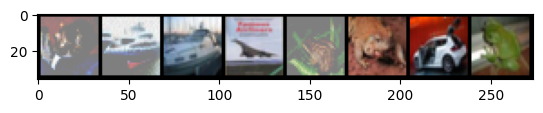

In [ ]:
# Get a batch of adversarial examples
for adv_images, labels in adv_loader_APGD:
    break

# Unnormalize for visualization
adv_images = adv_images * 0.5 + 0.5

# Show the images
grid = torchvision.utils.make_grid(adv_images[:8])
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [11]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')
    return accuracy

In [ ]:
evaluate(model, adv_loader_FGSM)

Accuracy on adversarial examples: 16.21%


16.21

In [ ]:
evaluate(model, adv_loader_MIM)

Accuracy on adversarial examples: 0.21%


0.21

In [ ]:
evaluate(model, adv_loader_PGD)

Accuracy on adversarial examples: 0.43%


0.43

In [ ]:
evaluate(model, adv_loader_APGD)

Accuracy on adversarial examples: 0.35%


0.35

SAGA attacks:

In [6]:
# Load the pre-trained weights
model_checkpoint_path = "resnet56_cifar10_2.pth"  # Ensure the file exists in this directory
if os.path.exists(model_checkpoint_path):
    model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print("Pretrained ResNet-56 model loaded successfully!")
else:
    print(f"Checkpoint not found at {model_checkpoint_path}")

# Set model to evaluation mode
model.eval()

<ipython-input-6-26aa7ae730cc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))


Pretrained ResNet-56 model loaded successfully!


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      

In [7]:
from AttackWrappersSAGA import SelfAttentionGradientAttack
from ModelPlus import ModelPlus

In [8]:
# Parameters for SAGA
epsilon = 0.031  # Max perturbation
num_steps = 50  # Number of attack steps
step_size = epsilon / num_steps  # Step size
clip_min, clip_max = -1.0, 1.0  # Input clipping bounds
coefficients = [1.0]  # Single model, so single coefficient

# Wrap the ResNet-56 model
resnet_plus = ModelPlus(
    model=model,
    modelName="ResNet-56",
    device=device,
    imgSizeH=32,
    imgSizeW=32,
    batchSize=64
)
model_list_plus = [resnet_plus]  # Only ResNet-56

# Perform the SAGA attack on ResNet-56
saga_adv_loader = SelfAttentionGradientAttack(
    device=device,
    epsMax=epsilon,
    numSteps=num_steps,
    modelListPlus=model_list_plus,
    coefficientArray=coefficients,
    dataLoader=test_loader,
    clipMin=clip_min,
    clipMax=clip_max
)

print("SAGA attack completed successfully for ResNet-56!")

Running Step= 0


/content/drive/MyDrive/661FinalProject/ResNetPytorch.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.sm(out))


Running Step= 1
Running Step= 2
Running Step= 3
Running Step= 4
Running Step= 5
Running Step= 6
Running Step= 7
Running Step= 8
Running Step= 9
Running Step= 10
Running Step= 11
Running Step= 12
Running Step= 13
Running Step= 14
Running Step= 15
Running Step= 16
Running Step= 17
Running Step= 18
Running Step= 19
Running Step= 20
Running Step= 21
Running Step= 22
Running Step= 23
Running Step= 24
Running Step= 25
Running Step= 26
Running Step= 27
Running Step= 28
Running Step= 29
Running Step= 30
Running Step= 31
Running Step= 32
Running Step= 33
Running Step= 34
Running Step= 35
Running Step= 36
Running Step= 37
Running Step= 38
Running Step= 39
Running Step= 40
Running Step= 41
Running Step= 42
Running Step= 43
Running Step= 44
Running Step= 45
Running Step= 46
Running Step= 47
Running Step= 48
Running Step= 49
SAGA attack completed successfully for ResNet-56!


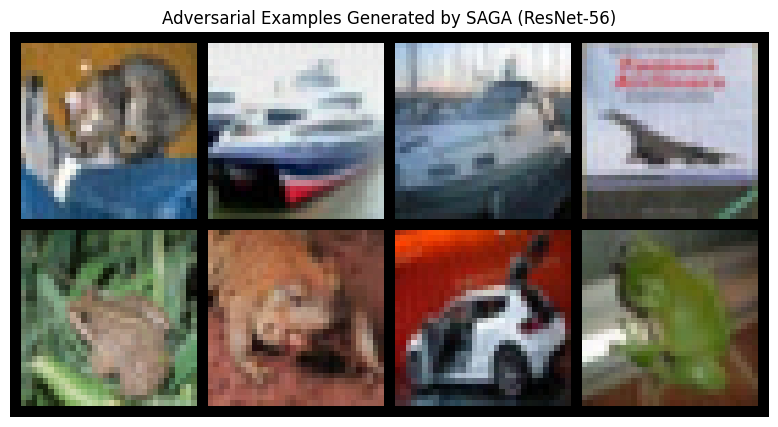

In [9]:
import matplotlib.pyplot as plt
import torchvision

# Get a batch of adversarial examples
for adv_images, labels in saga_adv_loader:
    break

# Unnormalize for visualization (assuming CIFAR-10 normalization: [-1, 1])
adv_images = adv_images * 0.5 + 0.5  # Scale back to [0, 1]

# Plot the adversarial images
grid = torchvision.utils.make_grid(adv_images[:8], nrow=4, padding=2)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Adversarial Examples Generated by SAGA (ResNet-56)")
plt.axis('off')
plt.show()

 ASR=100−Accuracy on adversarial examples (%)

In [12]:
# Evaluate the accuracy on the adversarial examples generated by SAGA
accuracy_on_adv = evaluate(model, saga_adv_loader)

# Compute the attack success rate (ASR)
attack_success_rate = 100 - accuracy_on_adv
print(f'Attack Success Rate (ASR): {attack_success_rate:.2f}%')


Accuracy on adversarial examples: 1.67%
Attack Success Rate (ASR): 98.33%
